# House prices prediction (kaggle.com)
In the Ames Housing dataset on kaggle, we would like to predict house prices with regression models. Thanks to @Serigne on kaggle.com for some helpful hints. 

1. [Import and explore the data](#sec_import)<br>
2. [Clean, fill in the missing data, and remove outliers](#sec_clean)<br>
 2.1 [Fill in the missing data](#sec_fill_missing)<br>
 2.2 [Convert to numeric values or dummies](#sec_convert_to_numeric_or_dummies)<br>
     2.2.1 [Convert categorial features to dummies](#sec_convert_to_dummies)<br>
     2.2.2 [Convert categorial features to numeric values](#sec_convert_to_numeric)<br>


### Import Libraries

In [1]:
import pandas as pd
from sklearn import model_selection, linear_model, ensemble, metrics
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
import xgboost as xgb
from sklearn.base import clone
from sklearn.kernel_ridge import KernelRidge
from scipy.stats import skew

<a id = 'sec_import'></a>
## 1. Import and explore the data 

In [2]:
trData = pd.read_csv('train.csv')
testData = pd.read_csv('test.csv')
data_list = [trData, testData]
ltr = len(trData)
ltest = len(testData)

In [3]:
print("The size of the training data is {}.".format(trData.shape))
print("The size of the test data is {}.".format(testData.shape))

The size of the training data is (1460, 81).
The size of the test data is (1459, 80).


The test and train data have almost the same number of samples (~1460)! 

In [4]:
trData.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
trData.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000,1460.000,1201.000,1460.000,1460.000,1460.000,1460.000,1460.000,1452.000,1460.000,...,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000
mean,730.500,56.897,70.050,10516.828,6.099,5.575,1971.268,1984.866,103.685,443.640,...,94.245,46.660,21.954,3.410,15.061,2.759,43.489,6.322,2007.816,180921.196
std,421.610,42.301,24.285,9981.265,1.383,1.113,30.203,20.645,181.066,456.098,...,125.339,66.256,61.119,29.317,55.757,40.177,496.123,2.704,1.328,79442.503
min,1.000,20.000,21.000,1300.000,1.000,1.000,1872.000,1950.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2006.000,34900.000
25%,365.750,20.000,59.000,7553.500,5.000,5.000,1954.000,1967.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,2007.000,129975.000
50%,730.500,50.000,69.000,9478.500,6.000,5.000,1973.000,1994.000,0.000,383.500,...,0.000,25.000,0.000,0.000,0.000,0.000,0.000,6.000,2008.000,163000.000
75%,1095.250,70.000,80.000,11601.500,7.000,6.000,2000.000,2004.000,166.000,712.250,...,168.000,68.000,0.000,0.000,0.000,0.000,0.000,8.000,2009.000,214000.000
max,1460.000,190.000,313.000,215245.000,10.000,9.000,2010.000,2010.000,1600.000,5644.000,...,857.000,547.000,552.000,508.000,480.000,738.000,15500.000,12.000,2010.000,755000.000


<a id = 'sec_clean'> </a>
## 2. Clean, fill in the missing data, and remove outliers

What are the missing data? 

In [6]:
trData.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
nullCounts = trData.isnull().sum()
nullCounts[nullCounts > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [8]:
nullCountsTest = testData.isnull().sum()
nullCountsTest[nullCountsTest > 0]

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64

In [9]:
def CheckNull(df, feature):
    print(df[feature].isnull().sum())

<a id = 'sec_fill_missing'> </a>
### 2.1 Fill in the missing data
We fill in the missing data with either mean() or mode(). 

In [10]:
testData['TotalBsmtSF'].fillna(testData['TotalBsmtSF'].mean(), inplace = True)
testData['GarageArea'].fillna(testData['GarageArea'].mean(), inplace = True)
testData['MSZoning'].fillna(testData['MSZoning'].mode()[0], inplace = True)
testData['SaleType'].fillna(testData['SaleType'].mode()[0], inplace = True)
for data in data_list:
    data['LotFrontage'].fillna(data['LotFrontage'].mean(), inplace = True)
    data['BsmtQual'].fillna('None', inplace = True)
    data['Functional'].fillna(data['Functional'].mode()[0], inplace = True)
    data['GarageYrBlt'].fillna(data['GarageYrBlt'].mean(), inplace = True)
    data['GarageCars'].fillna(data['GarageCars'].mode()[0], inplace = True)
    data['Electrical'].fillna(data['Electrical'].mode()[0], inplace = True)
    data['MasVnrType'].fillna(data['MasVnrType'].mode()[0], inplace = True)
    data['MasVnrArea'].fillna(data['MasVnrArea'].mean(), inplace = True)
    data['BsmtCond'].fillna('None', inplace = True)
    data['BsmtExposure'].fillna('None', inplace = True)
    data['GarageType'].fillna('None', inplace = True)
    data['BsmtFinSF1'].fillna(data['BsmtFinSF1'].mean(), inplace = True)
    data['BsmtFinSF2'].fillna(data['BsmtFinSF2'].mean(), inplace = True)
    data['BsmtUnfSF'].fillna(data['BsmtUnfSF'].mean(), inplace = True)
    data['PoolQC'].fillna('None', inplace = True)
    data['MiscFeature'].fillna('None', inplace = True)
    data['Alley'].fillna('None', inplace = True)
    data['Fence'].fillna('None', inplace = True)
    data['BsmtFullBath'].fillna(0, inplace = True)
    data['BsmtHalfBath'].fillna(0, inplace = True)
    data['Exterior1st'].fillna(data['Exterior1st'].mode()[0], inplace = True)
    data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0], inplace = True)
    data['BsmtFinType2'].fillna('None', inplace = True)
    data['FireplaceQu'].fillna('None', inplace = True)
    data['GarageFinish'].fillna('None', inplace = True)
    data['KitchenQual'].fillna(data['KitchenQual'].mode()[0], inplace = True)
    data['Exterior1st'].fillna(data['Exterior1st'].mode()[0], inplace = True)
    data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0], inplace = True)
    data['BsmtFinType1'].fillna('None', inplace = True)
    data['GarageQual'].fillna('None', inplace = True)
    data['GarageCond'].fillna('None', inplace = True)
    data['Utilities'].fillna('None', inplace = True)

In [11]:
testData['BsmtExposure'].value_counts()

No      951
Av      197
Gd      142
Mn      125
None     44
Name: BsmtExposure, dtype: int64

In [12]:
testData['BsmtFullBath'].value_counts()

0.000    851
1.000    584
2.000     23
3.000      1
Name: BsmtFullBath, dtype: int64

In [13]:
for data in data_list:
    data['GarageTypeSmple'] = data['GarageType']
    data['GarageTypeSmple'] = data['GarageType'].replace(['Basment', 'CarPort', '2Types'], 'Rare')
    data['ExterCondSmple'] = data['ExterCond'].replace(['Fa', 'Ex', 'Po'], 'Rare')
    data['HasDeckPorch'] = ((data['WoodDeckSF'] > 0) | (data['OpenPorchSF'] > 0) | (data['EnclosedPorch']) > 0 |
                            (data['3SsnPorch'] > 0) | (data['ScreenPorch'] > 0)) * 1
    data['HasPool'] = (data['PoolArea'] > 0) * 1
    data['HalfFullBath'] = data['FullBath'] + data['HalfBath']
    data['SaleTypeSmple'] = data['SaleType'].replace(['CoD', 'ConLD', 'ConLw', 'ConLI', 'Oth', 'Con', 'CWD'], 'Rare')

<a id = 'sec_convert_to_numeric_or_dummies'></a>
### 2.2 Convert to numeric or dummies
We now convert the non-numeric values to numeric values or dummies. The categorial type features will be converted to dummies and the rest of non-numeric features will be converted to numeric values accordingly. 

<a id = 'sec_convert_to_dummies'></a>
#### 2.2.1 Convert categorial to dummies
The following variables are categorial type features:

MSSubClass, MSZoning, Alley, LotShape, LotConfig, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, Foundation, Heating, Electrical, GarageType, SaleType, SaleCondition

In [14]:
combinedData = pd.concat(objs=[trData, testData], axis = 0).reset_index(drop = True)
combinedData = pd.get_dummies(combinedData, columns=['MSSubClass', 'MSZoning', 'Alley', 'Street', 'LotShape', 'LotConfig', 'Neighborhood', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'SaleType', 'SaleCondition'])
# trData = pd.get_dummies(trData, columns=['MSSubClass', 'MSZoning', 'Alley', 'Street', 'LotShape', 'LotConfig', 'Neighborhood', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'SaleType', 'SaleCondition'])
# testData = pd.get_dummies(testData, columns=['MSSubClass', 'MSZoning', 'Alley', 'Street', 'LotShape', 'LotConfig', 'Neighborhood', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'SaleType', 'SaleCondition'])
trData = combinedData[0:ltr].reset_index(drop = True)
testData = (combinedData[ltr:ltr+ltest].reset_index(drop = True)).drop('SalePrice', 1)

In [15]:
print(testData.shape)
print(trData.shape)

(1459, 198)
(1460, 199)


In [16]:
combinedData = pd.concat(objs = [trData, testData], axis=0).reset_index(drop = True)
conditionList = combinedData['Condition1'].unique()
Condition1Dummies = pd.get_dummies(combinedData['Condition1'], columns = ['Condition1'])
Condition2Dummies = pd.get_dummies(combinedData['Condition2'], columns = ['Condition2'])
ConditionDummies = Condition1Dummies
for colName in Condition2Dummies.columns:
    ConditionDummies[colName] += Condition2Dummies[colName]
    ConditionDummies[colName]  = (ConditionDummies[colName] > 0) * 1 # To prevent duplicates
ConditionDummies.drop('Norm', 1, inplace = True);
for colName in ConditionDummies.columns:
    trData[colName] = ConditionDummies[colName][0:ltr].reset_index(drop = True)
    testData[colName] = ConditionDummies[colName][ltr:ltr+ltest].reset_index(drop = True)

exteriorList = combinedData['Exterior1st'].unique()
exterior1Dummies = pd.get_dummies(combinedData['Exterior1st'], columns = ['Exterior1st'])
exterior2Dummies = pd.get_dummies(combinedData['Exterior2nd'], columns = ['Exterior2nd'])
exterior2Dummies.rename(columns={'Brk Cmn':'BrkComm', 'CmentBd':'CemntBd', 'Wd Shng':'WdShing'}, inplace = True);

exteriorDummies = exterior2Dummies
for colName in exterior1Dummies.columns:
    exteriorDummies[colName] += exterior1Dummies[colName]
    exteriorDummies[colName]  = (exteriorDummies[colName] > 0) * 1 # To prevent duplicates
for colName in exteriorDummies.columns:
    trData[colName] = exteriorDummies[colName][0:ltr].reset_index(drop = True)
    testData[colName] = exteriorDummies[colName][ltr:ltr+ltest].reset_index(drop = True)   

<a id = 'sec_convert_to_numeric'></a>
#### 2.2.2 Convert non-numeric, non-categorial to numeric
There are some featurs which are non-numeric but they is some relationship between different values of the features. For instance, the ratings such as Poor, Good, Excellent. For these types of features, we manually set the numeric values in an ascending or descending order. 

The following variables are non-numeric but also can be regarded as non-categorial:

LandContour, Utilities, LandSlope, OverallQual, OverallCond, ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, HeatingQC, KitchenQual, Functional, FireplaceQu, GarageFinish, GarageQual, GarageCond, PavedDrive, PoolQC, Fence

**LandCountour**:

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64


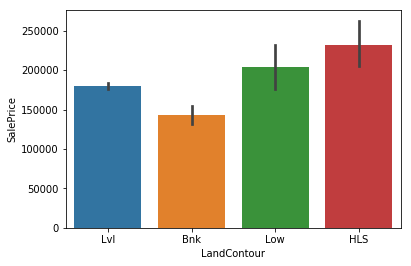

In [17]:
sns.barplot(x = trData['LandContour'], y = trData['SalePrice'])
print(trData['LandContour'].value_counts())

We expected that a Level countour be more expensive, but it does not seem to be the case on average. We decide to drop this feature as it does not seem meaningfull in relation to the saleprice. 

In [18]:
data_list = [trData, testData]
for data in data_list:
    data.drop('LandContour', 1, inplace = True)

**LandSlope**:

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64


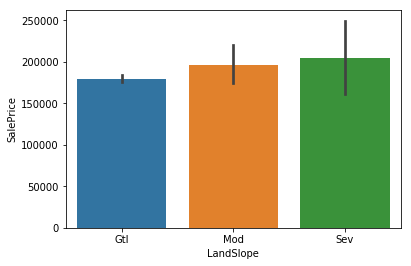

In [19]:
sns.barplot(x = trData['LandSlope'], y = trData['SalePrice'])
print(trData['LandSlope'].value_counts())

Similar to LandContour we drop this feature:

In [20]:
data_list = [trData, testData]
for data in data_list:
    data.drop('LandSlope', 1, inplace = True)

**Utilities**:

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64


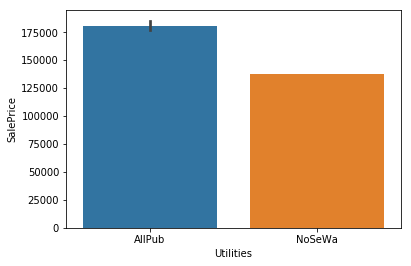

In [21]:
sns.barplot(x = trData['Utilities'], y = trData['SalePrice'])
print(trData['Utilities'].value_counts())

There is only one NoSeWa and the rest are AllPub. So, we drop this feature:

In [22]:
data_list = [trData, testData]
for data in data_list:
    data.drop('Utilities', 1, inplace = True)

**MiscFeature**:

In [23]:
data_list = [trData, testData]
for data in data_list:
    data.drop('MiscFeature', 1, inplace = True)

In [24]:
combinedData = pd.concat(objs = [trData, testData], axis = 0).reset_index(drop = True)
Ntr = len(trData)
Ntest = len(testData)
Ntot = len(combinedData)
label = LabelEncoder()
labelZone = LabelEncoder()
labelBldgType = LabelEncoder()
labelHouseStyle = LabelEncoder()
labelListOld = ['CentralAir', 
                'PavedDrive', 'BsmtQual', 'Functional',
                'ExterCond',  
                'ExterQual', 'GarageTypeSmple', 'ExterCondSmple', 
                'SaleTypeSmple', 'BsmtCond', 'PoolQC', 'Fence', 
                'HeatingQC', 'BsmtExposure',  'BsmtFinType1',
                'BsmtFinType2', 'FireplaceQu', 'GarageFinish', 'MoSold', 
               'YrSold', 'KitchenQual', 'GarageQual', 'GarageCond']
labelListNew = ['CentralAir', 
                'PavedDrive', 'BsmtQual', 'Functional', 
               'ExterCond', 
               'ExterQual', 'GarageTypeSmple', 'ExterCondSmple',
               'SaleTypeSmple', 'BsmtCond', 'PoolQC', 'Fence', 
               'HeatingQC', 'BsmtExposure', 'BsmtFinType1',
               'BsmtFinType2', 'FireplaceQu', 'GarageFinish', 'MoSold', 
               'YrSold', 'KitchenQual', 'GarageQual', 'GarageCond']

data_list = [trData, testData]
for data in data_list: 
    for i in range(len(labelListOld)):
        label_encoder = LabelEncoder()
        label_encoder.fit(combinedData[labelListOld[i]])
        data[labelListNew[i]] = label_encoder.transform(data[labelListOld[i]])

In [25]:
trData.dtypes[trData.dtypes == 'object']

Condition1     object
Condition2     object
Exterior1st    object
Exterior2nd    object
dtype: object

In [26]:
# combinedData = pd.concat(objs = [trData, testData], axis = 0).reset_index(drop = True)
# Ntr = len(trData)
# Ntest = len(testData)
# Ntot = len(combinedData)
# label = LabelEncoder()
# label.fit(combinedData['Neighborhood']) 
# labelZone = LabelEncoder()
# labelZone.fit(combinedData['MSZoning'])
# labelBldgType = LabelEncoder()
# labelBldgType.fit(combinedData['BldgType'])
# labelHouseStyle = LabelEncoder()
# labelHouseStyle.fit(combinedData['HouseStyle'])
# labelListOld = ['Neighborhood', 'MSZoning', 'BldgType', 'HouseStyle', 'Foundation', 'CentralAir', 
#                 'PavedDrive', 'SaleType', 'SaleCondition', 'BsmtQual', 'Heating', 'Functional',
#                 'Street', 'ExterCond', 'RoofMatl', 'RoofStyle', 'Condition1', 
#                 'Condition2', 'Electrical', 'MasVnrType', 'ExterQual', 'GarageTypeSmple', 'ExterCondSmple', 
#                 'SaleTypeSmple', 'BsmtCond', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 
#                 'HeatingQC', 'BsmtExposure', 'GarageType', 'LandSlope', 'LotConfig', 'LotShape', 
#                'Exterior1st', 'Exterior2nd', 'BsmtFinType2', 'FireplaceQu', 'GarageFinish', 'MoSold', 
#                'YrSold', 'KitchenQual']
# labelListNew = ['NeighborhoodCode', 'MSZoningCode', 'BldgTypeCode', 'HouseStyleCode', 'FoundationCode', 'CentralAirCode', 
#                 'PavedDriveCode', 'SaleTypeCode', 'SaleConditionCode', 'BsmtQualCode', 'HeatingCode', 'FunctionalCode', 
#                'StreetCode', 'ExterCondCode', 'RoofMatlCode', 'RoofStyleCode', 'Condition1Code', 
#                'Condition2Code', 'ElectricalCode', 'MasVnrTypeCode', 'ExterQualCode', 'GarageTypeSmpleCode', 'ExterCondSmpleCode',
#                'SaleTypeSmpleCode', 'BsmtCondCode', 'PoolQCCode', 'MiscFeatureCode', 'AlleyCode', 'FenceCode', 
#                'HeatingQCCode', 'BsmtExposureCode', 'GarageTypeCode', 'LandSlopeCode', 'LotConfigCode', 'LotShapeCode', 
#                'Exterior1stCode', 'Exterior2ndCode', 'BsmtFinType2Code', 'FireplaceQuCode', 'GarageFinishCode', 'MoSoldCode', 
#                'YrSoldCode', 'KitchenQualCode']

# for data in data_list: 
#     for i in range(len(labelListOld)):
#         label_encoder = LabelEncoder()
#         label_encoder.fit(combinedData[labelListOld[i]])
#         data[labelListNew[i]] = label_encoder.transform(data[labelListOld[i]])

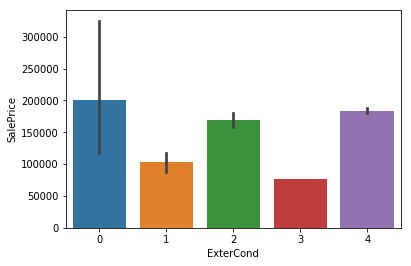

In [27]:
sns.barplot(x = trData['ExterCond'], y = trData['SalePrice'])

In [28]:
# for data in data_list:
#     data['ExterCondCode'] = data['ExterCond'].replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'], [0, 1, 2, 3, 4])

In [29]:
# sns.barplot(x = trData['ExterCondCode'], y = trData['SalePrice'])

In [30]:
combinedData = pd.concat(objs = [trData, testData], axis=0).reset_index(drop = True)

In [31]:
data_list = [trData, testData]
for data in data_list:
    data.drop('Condition1', 1, inplace = True)
    data.drop('Condition2', 1, inplace = True)
    data.drop('Exterior1st', 1, inplace = True)
    data.drop('Exterior2nd', 1, inplace = True)

### Graph the price (output) and features (input) distributions:

Text(0,0.5,'Counts')

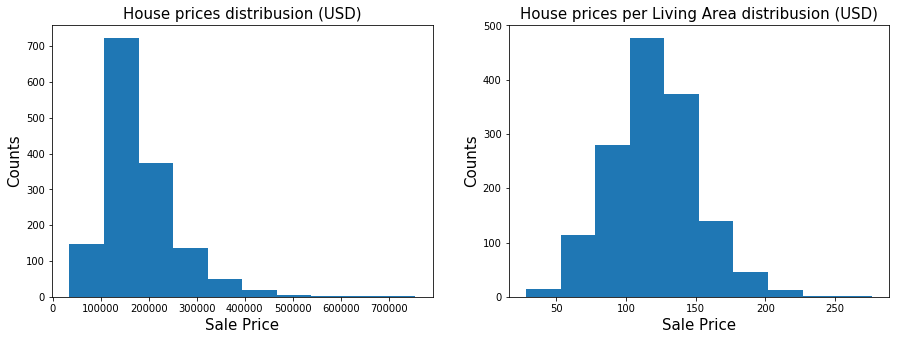

In [32]:
f, ax = plt.subplots(1, 2, figsize = (15, 5))
FZ = 15
ax[0].hist(trData['SalePrice'])
ax[0].set_title('House prices distribusion (USD)', fontsize = FZ)
ax[0].set_xlabel('Sale Price', fontsize = FZ)
ax[0].set_ylabel('Counts', fontsize = FZ)

ax[1].hist(trData['SalePrice'] / trData['GrLivArea'])
ax[1].set_title('House prices per Living Area distribusion (USD)', fontsize = FZ)
ax[1].set_xlabel('Sale Price', fontsize = FZ)
ax[1].set_ylabel('Counts', fontsize = FZ)

In [33]:
trData['PricePerArea'] = trData['SalePrice'] / trData['GrLivArea']
trData['PricePerArea'].mean()

120.57287807326857

For simplicity we will convert the price to $1000:

In [34]:
trData['SalePriceK'] = trData['SalePrice'] / 1000

The average house price per square feet of living area (GrLivArea) is around 120 USD. 

### 2.3 Regularize the data

In [35]:
trData["SalePriceLog"] = np.log1p(trData["SalePrice"])

### 2.3 Remove the outliers

Text(0.5,0,'GrLivArea')

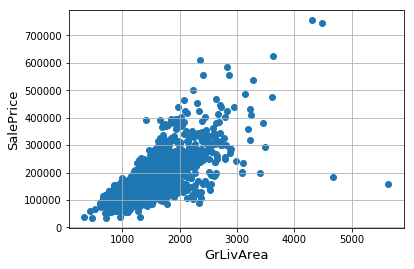

In [36]:
plt.scatter(x = trData['GrLivArea'], y = trData['SalePrice'])
plt.grid()
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)

In [37]:
trData.drop(trData[(trData['GrLivArea']>4000) & (trData['SalePrice']<300000)].index, inplace = True)
combinedData = pd.concat(objs = [trData, testData], axis = 0).reset_index(drop = True)

After removing the two outliers:

Text(0.5,0,'GrLivArea')

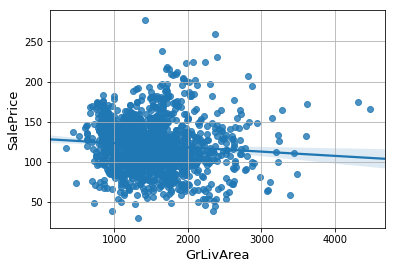

In [38]:
sns.regplot(x = trData['GrLivArea'], y = trData['SalePrice'] /trData['GrLivArea'])
plt.grid()
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)

In [39]:
# sns.barplot(x = trData['Neighborhood'], y = trData['SalePrice'] / trData['GrLivArea'])

In [40]:
# ngbhrData = trData[['Neighborhood', 'PricePerArea']].groupby('Neighborhood', as_index = False).mean()

In [41]:
# ngbhrData['PricePerArea']

In [42]:
# trData['Neighborhood'].value_counts()

Text(0.5,0,'GrLivArea')

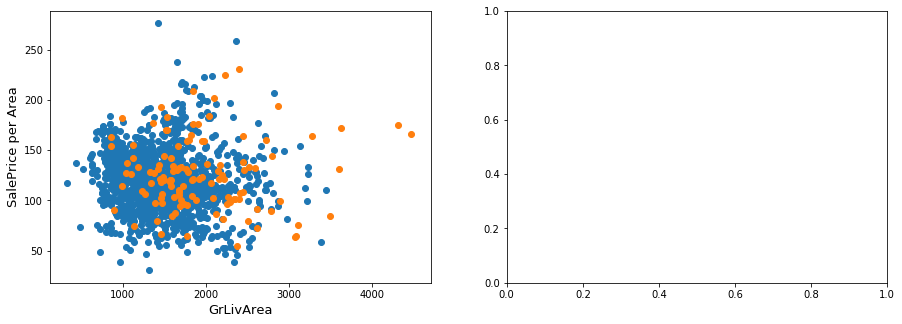

In [43]:
trDataNrmArea = trData[trData['LotArea'] <= 15000]
trDataLrgArea = trData[trData['LotArea'] > 15000]
f, ax = plt.subplots(1, 2, figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.scatter(x = trDataNrmArea['GrLivArea'], y = trDataNrmArea['SalePrice'] / trDataNrmArea['GrLivArea'])
plt.grid()
plt.ylabel('SalePrice per Area', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)

plt.scatter(x = trDataLrgArea['GrLivArea'], y = trDataLrgArea['SalePrice'] / trDataLrgArea['GrLivArea'])
plt.grid()
plt.ylabel('SalePrice per Area', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)

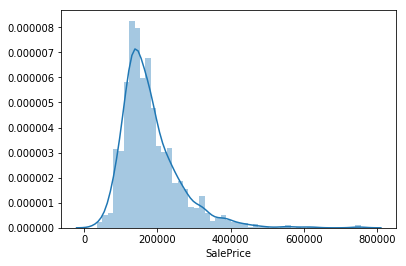

In [44]:
sns.distplot(trData['SalePrice'])

Another possiblity for outliers is the price per area. There is only one house with a price per square foot less than $31, and the next lowest price is $40, so, we remove the cheapest one:

In [45]:
trData[trData['SalePrice'] / trData['GrLivArea'] < 31]

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,...,Other,Plywood,Stone,Stucco,VinylSd,Wd Sdng,WdShing,PricePerArea,SalePriceK,SalePriceLog
30,649,668,0,3,4,3,0.000,0.000,6,6,...,0,0,0,0,0,0,0,30.372,40.000,10.597


In [46]:
trData.drop(trData[trData['SalePrice'] / trData['GrLivArea'] < 31].index, inplace = True)

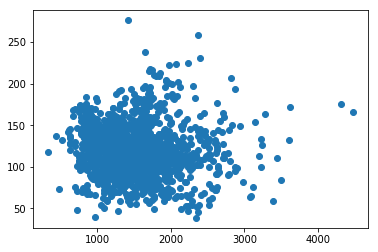

In [47]:
plt.scatter(x = trData['GrLivArea'], y = trData['SalePrice'] / trData['GrLivArea'])

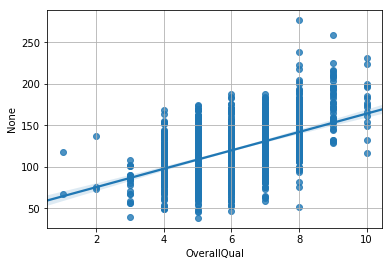

In [48]:
sns.regplot(x = trData['OverallQual'], y = trData['SalePrice'] / trData['GrLivArea'])
plt.grid()

In [49]:
trData['PoolQC'].value_counts()

3    1451
2       2
1       2
0       2
Name: PoolQC, dtype: int64

## 3. Feature engineering
We investigate the correlation between the features and the sale price.

In [50]:
# f, ax = plt.subplots(3, 3, figsize = (12, 10))
# plt.subplot(3, 3, 1)
# sns.regplot(x = 'GrLivArea', y = 'SalePriceK', data = trData)
# plt.subplot(3, 3, 2)
# sns.barplot(x = 'BedroomAbvGr', y = 'SalePriceK', data = trData)
# plt.subplot(3, 3, 3)
# sns.regplot(x = 'YearBuilt', y = 'SalePriceK', data = trData)
# plt.subplot(3, 3, 4)
# sns.barplot(x = 'OverallCond', y = 'SalePriceK', data = trData)
# plt.subplot(3, 3, 5)
# sns.barplot(x = 'OverallQual', y = 'SalePriceK', data = trData)
# plt.subplot(3, 3, 6)
# sns.barplot(x = 'MoSold', y = 'SalePriceK', data = trData)
# plt.subplot(3, 3, 7)
# sns.barplot(x = 'Neighborhood', y = 'SalePriceK', data = trData)
# plt.subplot(3, 3, 8)
# sns.barplot(x = 'MSZoning', y = 'SalePriceK', data = trData)
# plt.subplot(3, 3, 9)
# sns.barplot(x = 'Condition2', y = 'SalePriceK', data = trData)
# plt.tight_layout() 

In [51]:
# # tmpData = trData
# # tmpData['1stFlrSF_2ndFlrSF'] = trData['1stFlrSF'] + trData['2ndFlrSF']
# sns.barplot(x = 'Alley', y = 'SalePriceK', data = trData)
# print(trData['Alley'].value_counts())
# CheckNull(combinedData, 'BsmtCond')

In [52]:
CheckNull(combinedData, 'ExterQual')

0


In [53]:
# for data in data_list:
#     data['GarageCarsSmple'] = data['GarageCars'].replace(4, 3)

In [54]:
# sns.barplot(x = 'HalfFullBath', y = 'SalePriceK', data = trData)
# print(trData['HalfFullBath'].value_counts())

In [55]:
# sns.barplot(x = 'HasDeckPorch', y = 'SalePriceK', data = trData)
# print(trData['HasDeckPorch'].value_counts())

In [56]:
# sns.regplot(x = 'LowQualFinSF', y = 'SalePriceK', data = trData)
# print(trData['LowQualFinSF'].value_counts())
# CheckNull(combinedData, 'LowQualFinSF')

Since only 'Gd' condition has a significant different with the rest, we define a new feature: 

In [57]:
# for data in data_list:
#     data['BsmtExposureGd'] = (data['BsmtExposure'] == 'Gd') * 1

In [58]:
data_list = [trData, testData]
for data in data_list:
    data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
    data['TotalBath'] = data['BsmtFullBath'] + data['BsmtHalfBath'] + data['FullBath'] + data['HalfBath']
    data['TotalPorch'] = data['WoodDeckSF'] + data['OpenPorchSF'] + data['EnclosedPorch'] + data['3SsnPorch'] + data['ScreenPorch'] 
    data['TotalBsmtFinSF'] = data['BsmtFinSF1'] + data['BsmtFinSF2']

ValueError: Could not interpret input 'HouseStyle'

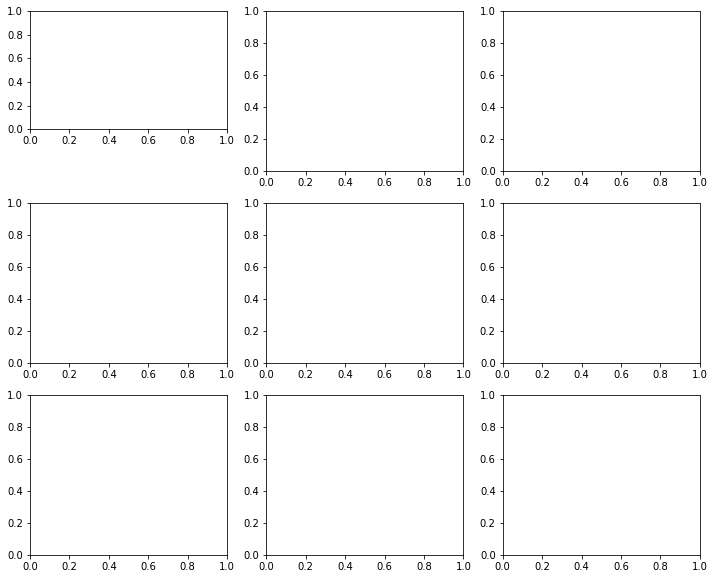

In [59]:
f, ax = plt.subplots(3, 3, figsize = (12, 10))
plt.subplot(4, 3, 1)
sns.barplot(x = 'HouseStyle', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 2)
sns.barplot(x = 'ExterCond', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 3)
sns.barplot(x = 'CentralAir', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 4)
sns.barplot(x = 'PavedDrive', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 5)
sns.barplot(x = 'LotConfig', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 6)
sns.barplot(x = 'BsmtQual', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 7)
sns.barplot(x = 'Neighborhood', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 8)
sns.barplot(x = 'Functional', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 9)
sns.regplot(x = 'YearRemodAdd', y = 'SalePriceK', data = trData)
plt.tight_layout() 
plt.subplot(4, 3, 10) 
sns.barplot(x = 'BsmtQual', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 11) 
sns.barplot(x = 'OverallCond', y = 'SalePriceK', data = trData) 
plt.subplot(4, 3, 12) 
sns.regplot(x = 'GarageYrBlt', y = 'SalePriceK', data = trData)

House age seems to be an important feature correlated with the saleprice:

In [60]:
ngbhrData = trData[['Neighborhood', 'PricePerArea']].groupby('Neighborhood').mean()
MSSubClassVsPricePerArea = combinedData[['MSSubClass', 'PricePerArea']].groupby('MSSubClass').mean()
MSZoningVsPricePerArea = trData[['MSZoning', 'PricePerArea']].groupby('MSZoning').mean()
HouseStylePricePerArea = combinedData[['HouseStyle', 'PricePerArea']].groupby('HouseStyle').mean()
SaleTypePricePerArea = combinedData[['SaleType', 'PricePerArea']].groupby('SaleType').mean()
SaleConditionPricePerArea = combinedData[['SaleCondition', 'PricePerArea']].groupby('SaleCondition').mean()

KeyError: "['Neighborhood'] not in index"

In [61]:
MSSubClassVsPricePerArea.fillna(MSSubClassVsPricePerArea['PricePerArea'].mean(), inplace = True)

NameError: name 'MSSubClassVsPricePerArea' is not defined

In [62]:
len(combinedData['MSSubClass'].value_counts())

KeyError: 'MSSubClass'

In [63]:
plt.plot(HouseStylePricePerArea, '.-')

NameError: name 'HouseStylePricePerArea' is not defined

In [64]:
# trData['Neighborhood'].value_counts()

In [65]:
# for data in data_list:
#     data['NeighborhoodPrice'] = data['Neighborhood'].apply(lambda x: ngbhrData['PricePerArea'][x])
#     data['MSSubClassPrice'] = data['MSSubClass'].apply(lambda x: MSSubClassVsPricePerArea['PricePerArea'][x])
#     data['MSZoningPrice'] = data['MSZoning'].apply(lambda x: MSZoningVsPricePerArea['PricePerArea'][x])
#     data['HouseStylePrice'] = data['HouseStyle'].apply(lambda x: HouseStylePricePerArea['PricePerArea'][x])
#     data['SaleTypePrice'] = data['SaleType'].apply(lambda x: SaleTypePricePerArea['PricePerArea'][x]) 
#     data['SaleConditionPrice'] = data['SaleCondition'].apply(lambda x: SaleConditionPricePerArea['PricePerArea'][x])        

In [66]:
trData['YearBuilt'].describe()

count   1457.000
mean    1971.253
std       30.174
min     1872.000
25%     1954.000
50%     1973.000
75%     2000.000
max     2010.000
Name: YearBuilt, dtype: float64

In [67]:
data_list = [trData, testData]
for data in data_list:
    data['HouseAge'] = data['YrSold'] - data['YearBuilt']
    data['YrfromRemod'] = data['YrSold'] - data['YearRemodAdd']
#     data['YrSoldFrom2006'] = data['YrSold'] - 2006
#     data['YrBuiltFrom1971'] = data['YearBuilt'] - 1971

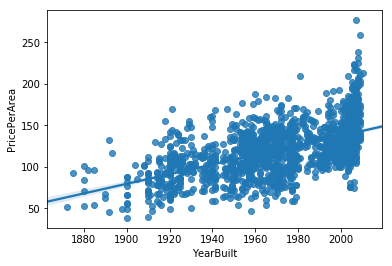

In [68]:
sns.regplot(x = 'YearBuilt', y = 'PricePerArea', data = trData)

Regularization: (thanks to @papiu on kaggle.com)

In [69]:
combinedData = pd.concat(objs=[trData, testData], axis = 0).reset_index(drop = True)

#log transform skewed numeric features:
numeric_feats = combinedData.dtypes[combinedData.dtypes != "object"].index
skewed_feats = combinedData[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
combinedData[skewed_feats] = np.log1p(combinedData[skewed_feats])
ltr = len(trData)
ltest = len(testData)
trData = combinedData[0:ltr].reset_index(drop = True)
testData = combinedData[ltr:ltr+ltest].reset_index(drop = True).drop(['SalePrice', 'SalePriceK', 'SalePriceLog', 'PricePerArea'], 1)

In [70]:
trData.shape

(1457, 224)

In [71]:
testData.shape

(1459, 220)

In [72]:
cor_col = ['GrLivArea', 'HouseAge', 'OverallCond', 'OverallQual', 'KitchenAbvGr', 'GarageArea', 
           'Functional', 'TotalBsmtSF',  'MSSubClass', 'NeighborhoodCode', 'MSZoningCode',
           'BldgTypeCode', 'HouseStyleCode', 'FoundationCode', 'CentralAirCode', 'PavedDriveCode', 
           'LotArea', 'RoofStyleCode', 'SalePrice']
cor_col = ['GrLivArea', 'OverallQual', 'BsmtFinSF1', 'HouseAge', 'NeighborhoodPrice', 'YearRemodAdd', 
           'GarageCarsSmple', 'LotArea', 'OverallCond', 'Fireplaces',
           'HouseStyleCode', 'MSSubClass',  'BsmtQualCode', 'PavedDriveCode', 'TotalSF', 
           'MSZoningCode', 'BsmtExposureCode', 'FunctionalCode', 'NeighborhoodCode', 
           'SalePriceK'
                    ]

In [73]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(trData[cor_col])

KeyError: "['NeighborhoodPrice' 'GarageCarsSmple' 'HouseStyleCode' 'MSSubClass'\n 'BsmtQualCode' 'PavedDriveCode' 'MSZoningCode' 'BsmtExposureCode'\n 'FunctionalCode' 'NeighborhoodCode'] not in index"

In [74]:
cor_col_smpl = ['GrLivArea', 'OverallQual', 'BsmtFinSF1', 'HouseAge', 'NeighborhoodCode', 'YearRemodAdd', 
           'SalePriceK']
sns.pairplot(trData[cor_col_smpl])
plt.show()

KeyError: "['NeighborhoodCode'] not in index"

In [75]:
plt.scatter(x = trData['SaleCondition'], y = trData['PricePerArea'])

KeyError: 'SaleCondition'

## 4. Train the models and predict

In [76]:
selected_features = ['GrLivArea', 'HouseAge', 'OverallQual', 'BedroomAbvGr', 'KitchenAbvGr', 
                     'FullBath', 'GarageArea', 'Fireplaces', 'MSSubClass', 
                     'MSZoningCode', 'BldgTypeCode', 'HouseStyleCode', 
                     'FoundationCode', 'CentralAirCode', 'PavedDriveCode', 'LotArea', 
                     'YearRemodAdd', 'BsmtQualCode', 'TotRmsAbvGrd', 'OverallCond',
                     'MasVnrTypeCode', 'BsmtExposureGd', 'YearBuilt', 'GarageTypeSmpleCode', 'GarageCarsSmple',
                     'HasDeckPorch', 'BsmtFinSF1', 'NeighborhoodCode', 'TotalSF', 'FunctionalCode', 'ElectricalCode']
# good GarageCarsSmple HouseStyleCode CentralAirCode BsmtQualCode OverallCond Fireplaces TotalBsmtSF MSSubClass MSZoningCode
# bad BsmtExposureGd GarageArea FoundationCode LandContour HasDeckPorch FullBath MasVnrTypeCode BedroomAbvGr
# bad PavedDriveCode BldgTypeBsmtExposureGdCode GarageTypeSmpleCode KitchenAbvGr
selected_features = ['GrLivArea', 'OverallQual', 'BsmtFinSF1', 'HouseAge', 'YearRemodAdd', 
                    'GarageCars', 'LotArea', 'OverallCond', 'Fireplaces',
                    'MSSubClassPrice',  'BsmtQualCode', 'PavedDriveCode', 'TotalSF', 
                    'BsmtExposureGd', 'ElectricalCode', 'FunctionalCode', 'NeighborhoodPrice', 'MSZoningPrice',
                    'SaleTypePrice', 'SaleConditionPrice', 
                    'ExterCondCode',
                     'Artery', 'Feedr', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNe', 'RRNn',
                    'AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'CemntBd',
                    'HdBoard', 'ImStucc', 'MetalSd', 'Other', 'Plywood', 'Stone', 'Stucco',
                    'VinylSd', 'Wd Sdng', 'WdShing',
                    '1.5Fin', '1.5Unf', '1Story', '2.5Fin', '2.5Unf', '2Story', 'SFoyer',
                    'SLvl'
                    ]

X = trData.drop(['SalePrice', 'SalePriceK', 'SalePriceLog', 'PricePerArea', 'Id'], 1)
y = trData['SalePrice']

In [77]:
Xtrain, Xtest, ytrain, ytest = model_selection.train_test_split(X, y, test_size = 0.5, train_size = 0.5, random_state=1)

In [78]:
n_folds = 10
def rmsle_cv(model):
    kf = model_selection.KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X)
    rmse= np.sqrt(-model_selection.cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = kf))
    return(sum(rmse)/n_folds)

In [79]:
kRR = KernelRidge(alpha = 1, degree = 1)

In [98]:
clfList = [linear_model.LinearRegression(), ensemble.RandomForestRegressor(), ensemble.GradientBoostingRegressor(),
          xgb.XGBRegressor(), KernelRidge()]
cvSplit = model_selection.ShuffleSplit(n_splits = 10, train_size = 0.5, test_size = 0.5, random_state = 0)
maxDepthList = [2, 4, 6, 8, 10]
nEstimatorsList = [10, 50, 100, 300]
etaList = [0.1, 0.05, 0.01]
gridSeedList = [0]
gammaList = [0, 0.1, 0.2, 0.5, 1]
colsample_bytreeList = [0.4, 0.5, 0.6, 1]
alphaList = [0.5, 1, 2]
degreeList = [1, 2, 3]
gridBool = [True, False]
paramGridList = [
                [{'fit_intercept': gridBool}], [{'max_depth': maxDepthList, 'random_state': gridSeedList}],
                [{'n_estimators': nEstimatorsList, 'max_depth': maxDepthList, 'random_state': gridSeedList}], 
                [{'max_depth': maxDepthList, 'gamma': gammaList, 'colsample_bytree': colsample_bytreeList}],
                [{'alpha': alphaList, 'degree': degreeList}]
                ]
bestScoreList = []
for clf, param in zip(clfList, paramGridList):
    bestSearch = model_selection.GridSearchCV(estimator = clf, param_grid = param, 
                                              cv = cvSplit, scoring = 'neg_mean_squared_error', n_jobs = 4)
    bestSearch.fit(X, y)
    bestParam = bestSearch.best_params_
    bestScore = round((-bestSearch.best_score_)**0.5, 5) 
    print('The best parameter for {} is {} with a runtime of seconds with an error of {}'.format(clf.__class__.__name__, bestParam, bestScore))
    clf.set_params(**bestParam) 
    bestScoreList.append(bestScore)
print("--"*45, "\nMax cross-validation score is {}".format(round(min(bestScoreList), 5)))
print("--"*45, "\nAverage cross-validation score is {}".format(sum(sorted(bestScoreList, reverse=False)[0:2]) / 2))

The best parameter for LinearRegression is {'fit_intercept': False} with a runtime of seconds with an error of 0.13588
The best parameter for RandomForestRegressor is {'max_depth': 10, 'random_state': 0} with a runtime of seconds with an error of 0.151
The best parameter for GradientBoostingRegressor is {'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of seconds with an error of 0.1234
The best parameter for XGBRegressor is {'colsample_bytree': 0.5, 'max_depth': 4, 'gamma': 0} with a runtime of seconds with an error of 0.12533
The best parameter for KernelRidge is {'alpha': 2, 'degree': 1} with a runtime of seconds with an error of 0.11705
------------------------------------------------------------------------------------------ 
Max cross-validation score is 0.11705
------------------------------------------------------------------------------------------ 
Average cross-validation score is 0.120225


In [99]:
# Thanks to Serigne on kaggle.com
class AveragingModels():
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [100]:
LassoRobust = make_pipeline(RobustScaler(), linear_model.Lasso(alpha =100, random_state=1))
ENet = make_pipeline(RobustScaler(), linear_model.ElasticNet(alpha=0.5, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [123]:
# averaging
averagingC = AveragingModels(models = (clfList[2], clfList[3], clfList[4]))
averagingC.fit(Xtrain, ytrain) # Note we fit the Whole X, y
arpredict = averagingC.predict(Xtest)
print(metrics.mean_squared_error(ytest, arpredict)**0.5)
predData = pd.DataFrame({'Index':ytest.index, 'SalePrice': ytest.values, 'SalePricePredicted':arpredict,
                         'Error': arpredict - ytest.values})

0.115941354226


In [124]:
averagingC.fit(X, y) # Note we fit the Whole X, y
arpredict = averagingC.predict(Xtest)
print(metrics.mean_squared_error(ytest, arpredict)**0.5)
predData = pd.DataFrame({'Index':ytest.index, 'SalePrice': ytest.values, 'SalePricePredicted':arpredict,
                         'Error': arpredict - ytest.values})

0.0722378919935


In [ ]:
# votingC = clfList[2]
# votingC.fit(Xtrain, ytrain) # Note we fit the Whole X, y
# arpredict = votingC.predict(Xtest)
# print(metrics.mean_squared_log_error(ytest, arpredict)**0.5)
# predData = pd.DataFrame({'Index':ytest.index, 'SalePrice': ytest.values, 'SalePricePredicted':arpredict,
#                          'Error': arpredict - ytest.values})

In [ ]:
# votingC = clfList[2]
# votingC.fit(X, y) # Note we fit the Whole X, y
# arpredict = votingC.predict(Xtest)
# print(metrics.mean_squared_log_error(ytest, arpredict)**0.5)
# predData = pd.DataFrame({'Index':ytest.index, 'SalePrice': ytest.values, 'SalePricePredicted':arpredict,
#                          'Error': arpredict - ytest.values})

In [125]:
trsh = 50000
print(len(Xtest[abs(np.expm1(arpredict) - np.expm1(ytest.values)) > trsh]))
predData[abs(arpredict - ytest.values) > trsh]

6


,Error,Index,SalePrice,SalePricePredicted


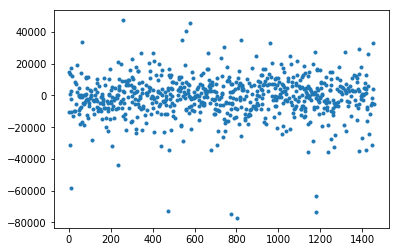

In [126]:
plt.plot((np.expm1(arpredict))-np.expm1(ytest), '.')

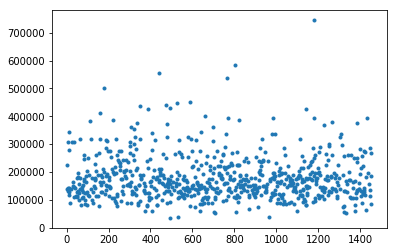

In [127]:
plt.plot((np.expm1(ytest)), '.')

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

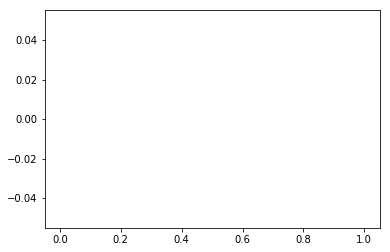

In [128]:
plt.hist(Xtest[abs(arpredict - ytest.values) > trsh]['OverallQual'])

In [129]:
ytest[abs(arpredict - ytest.values) > 100000]

Series([], Name: SalePrice, dtype: float64)

In [138]:
testDataTemp = testData.drop(['Id'], 1)
arpredict = averagingC.predict(testDataTemp)
arpredict = np.expm1(arpredict)
ypredict = pd.DataFrame({'Id': testData['Id'], 'SalePrice':arpredict})
ypredict.to_csv('../predictions.csv', index = False)

In [139]:
ypredict.head()

,Id,SalePrice
0,1461,123047.755
1,1462,160636.957
2,1463,188751.986
3,1464,190415.651
4,1465,193684.515


In [132]:
yold = pd.read_csv('../predictions2.csv')

In [133]:
yold.head()

,Id,SalePrice
0,1461,113415.127
1,1462,160004.426
2,1463,189772.107
3,1464,192616.792
4,1465,193625.922


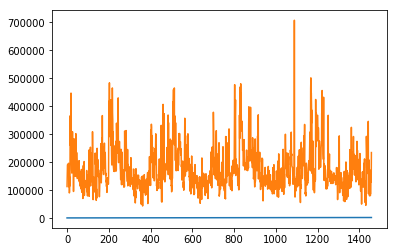

In [134]:
plt.plot(yold)

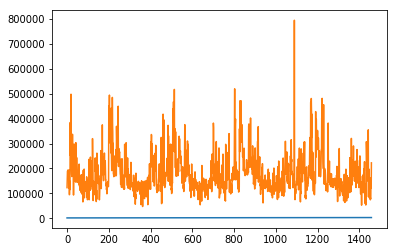

In [135]:
plt.plot(ypredict)

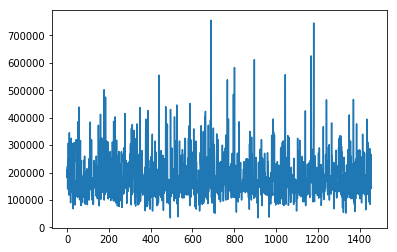

In [136]:
plt.plot(np.expm1(trData['SalePrice']))

In [137]:
print(metrics.mean_squared_log_error(yold, ypredict)**0.5)


0.0318279373687
